# MvsH

#### Import Modules

In [18]:
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
import glob
import scipy
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d

# some global plotting parameters
plt.rcParams['font.size'] = 22.5
plt.rcParams['axes.linewidth'] = 2.5

# set font to bold and Arial
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams['font.sans-serif'] = "Arial"

plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
plt.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
plt.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'

#### Specify path to Sample info and Pd Standard

In [19]:
# Replace this line depending on where you put your files
os.chdir('/Users/Kyle/Documents/UCSD/Research/Paper_2/Fig_3_Magnetism')

Samples_info = pd.read_csv("Non_Silica_Shell_Data.txt", delim_whitespace=True)
Pd_Std = pd.read_csv('Pd_Std_MvsH_300K.csv')

In [20]:
Samples_info

,Sample,Size,Ligand_percentage,Stdev,Xmax,Gamma,Ms
0,KMK273,5.43,25.138,0.62,300.028,0.154,72.686
1,KMK249,7.83,20.267,1.05,652.053,0.065,66.223
2,KMK254,9.57,13.885,1.01,939.972,0.059,87.375
3,KMK242,11.00,13.080,1.08,1005.036,0.052,82.214
4,KMK245,12.33,14.389,1.61,1428.259,0.039,86.946


In [21]:
Sample_Name = 'KMK245'
sample = Sample_Name

os.chdir('/Users/Kyle/Downloads/Testing')

MvsH_300K_file = sample + '_MvsH_300K.dat'

MvsH_files = [MvsH_300K_file]

Sample_info = Samples_info[Samples_info.Sample.isin([Sample_Name]) == True]

#### MvsH: Import and manipulate data

In [22]:
FO_Mass_Percent = (100 - float(Sample_info.Ligand_percentage)) / 100

MvsH = []
Temps = []

for file in MvsH_files:
    MvsH_temp = pd.read_csv(file, header = 40) #import MvsH file
    MvsH_temp = MvsH_temp.dropna(axis=1, how ='all') # drop columns containing NaN

    MvsH_temp = MvsH_temp[['Temperature (K)', 'Magnetic Field (Oe)', 'DC Moment Free Ctr (emu)']] #extract important columns
    MvsH_temp.rename(columns = {'Temperature (K)':'Temp', 'Magnetic Field (Oe)': 'Field', 'DC Moment Free Ctr (emu)': 'Moment_emu'}, inplace=True)

    Mass = pd.read_csv(file, skiprows=23, nrows=0) # import mass
    sample_mass = float(Mass.columns[1])/1000 # convert mg to g
    
    MvsH_temp.Field = MvsH_temp.Field / 10000 #convert Oe to T
      
    MvsH_temp['Moment_emu_g'] = (MvsH_temp.Moment_emu) / (sample_mass * FO_Mass_Percent)  # convert emu to emu/g
    
    # For KMK316 only
    #MvsH_temp['Moment_emu_g'] = (MvsH_temp.Moment_emu) / 0.00010405
    
    MvsH_temp.Temp = MvsH_temp.Temp.round(0) # round temperature

    temps = np.unique(MvsH_temp.Temp) #identify unique temperatures
    
    # Append data into global array
    MvsH.append(MvsH_temp)
    Temps.append(temps[0])

#### MvsH: Plot

In [23]:
MvsH[0]['Field_True'] = Pd_Std['Field_True'].values/10000

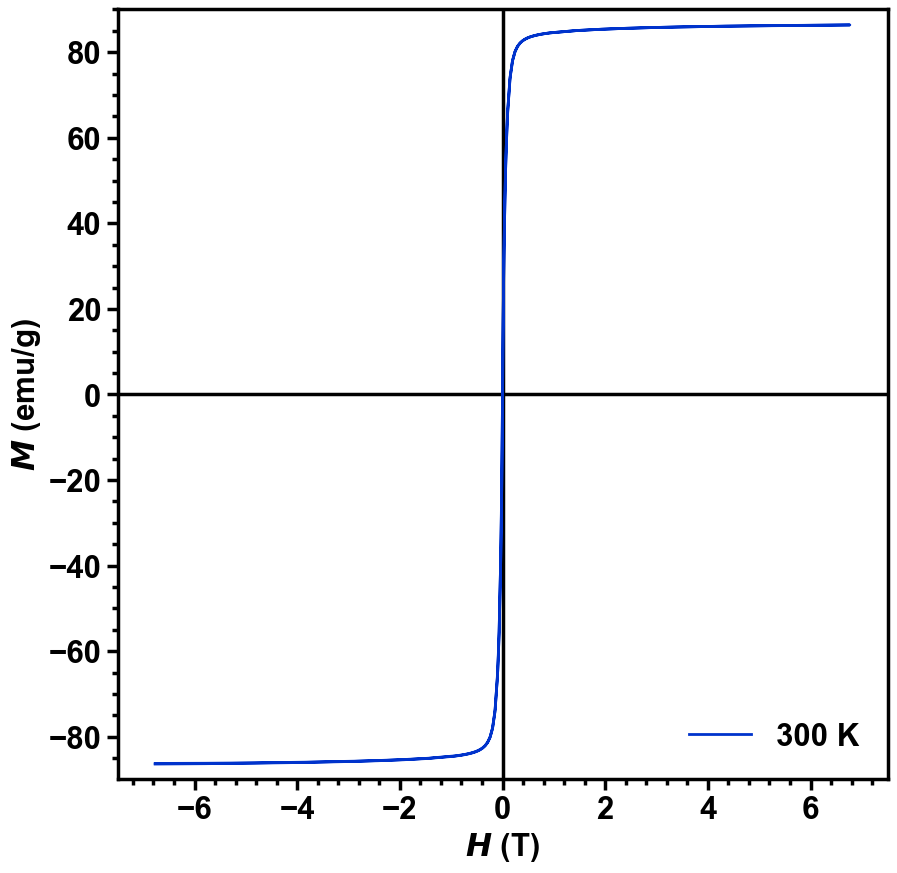

In [25]:
fig = plt.figure(1, figsize = (10,10))

# custom colormap
colors = ['#0033CC','#009966','#A3142E','#7D2E8F','#a6d854']

# horizontal and vertical lines
plt.axhline(y=0, xmin=0, xmax=1, linewidth=2.5, color = 'k', zorder=0)
plt.axvline(x=0, ymin=0, ymax=1, linewidth=2.5, color='k', zorder=0)

# pulls the unique temperatures and converts to strings for the legend
temps_text = []
for i in range (len(Temps)):
    temps_text.append(str(int(Temps[i])) + ' K')

for i in range (len(MvsH)):
    plt.plot(MvsH[i].Field_True, MvsH[i].Moment_emu_g,
             linewidth = 2,
             color = colors[i], 
             label = temps_text[i])

# plot parameters
plt.xlabel('$H$' + ' (T)')
plt.ylabel('$M$' + ' (emu/g)')

plt.xlim([-7.5, 7.5])
plt.ylim([-90, 90])

plt.legend(frameon = False, loc = 'lower right')

ax=plt.gca()
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')

plt.minorticks_on()
plt.tick_params(which = 'minor', width=2.5, length=4)
plt.tick_params(which = 'major', width=2.5, length=8)
ax.xaxis.set_minor_locator(AutoMinorLocator(5))
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')

# export as .png
plt.savefig(sample + '_MvsH.png', dpi = 1000, bbox_inches = 'tight')

# save as .txt
MvsH[0].to_csv(sample + '_' + str(int(Temps[0])) + 'K' + '_MvsH.csv')

In [32]:
ZFCFC_file = sample + '_ZFCFC.dat'

ZFCFC = pd.read_csv(ZFCFC_file, header = 40) # import ZFCFC file
ZFCFC = ZFCFC.dropna(axis=1, how ='all') # drop columns containing NaN

ZFCFC = ZFCFC[['Temperature (K)', 'Magnetic Field (Oe)', 'DC Moment Free Ctr (emu)']] #extract important columns
ZFCFC.rename(columns = {'Temperature (K)':'Temp', 'Magnetic Field (Oe)': 'Field', 'DC Moment Free Ctr (emu)': 'Moment_emu'}, inplace=True)

Mass = pd.read_csv(ZFCFC_file, skiprows=23, nrows=0) # import mass
sample_mass = float(Mass.columns[1])/1000 # convert mg to g

ZFCFC.Field = ZFCFC.Field / 10000 # convert Oe to T
ZFCFC['Moment_emu_g'] = ZFCFC.Moment_emu / (sample_mass*float(FO_Mass_Percent*100)) # convert emu to emu/g

ZFCFC_start = 0
ZFCFC_end = int((len(ZFCFC) -1)/2)

FC_start = int(ZFCFC_end + 1)
FC_end = len(ZFCFC)

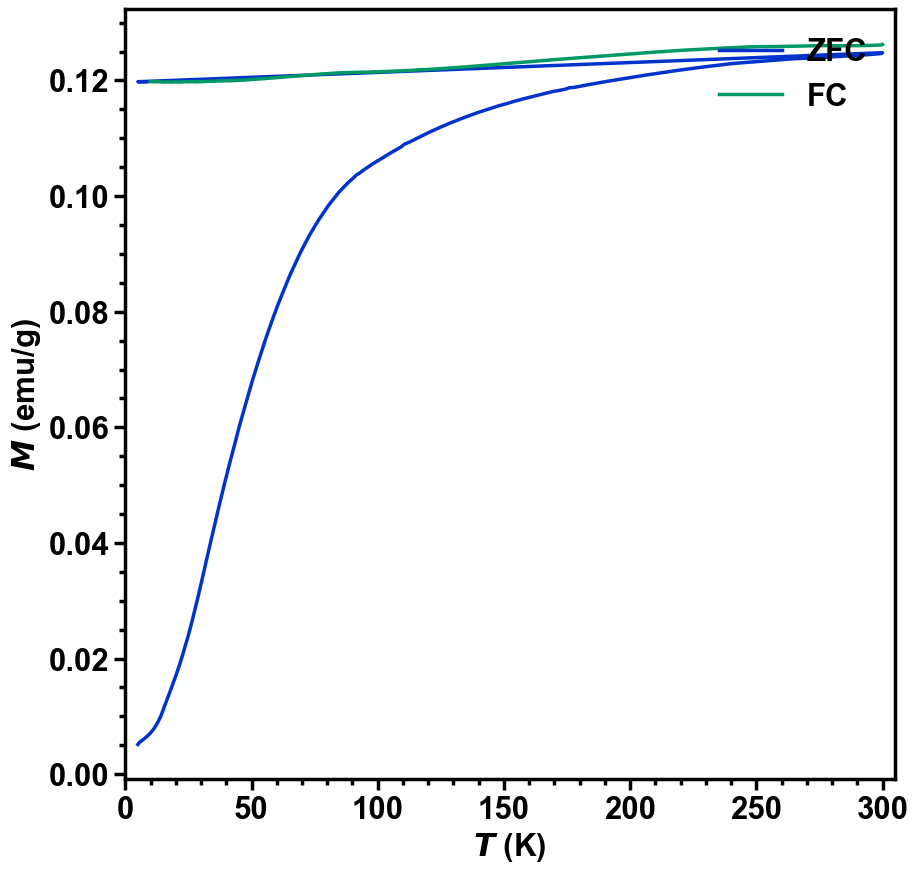

In [35]:
fig = plt.figure(2, figsize = (10,10))

colors = ['#0033CC','#009966','#A3142E','#7D2E8F','#a6d854']
    
plt.plot(ZFCFC.Temp[ZFCFC_start:ZFCFC_end], ZFCFC.Moment_emu_g[ZFCFC_start:ZFCFC_end],
        linewidth = 2.5,
        color = colors[0],
        label = 'ZFC')

plt.plot(ZFCFC.Temp[FC_start:FC_end], ZFCFC.Moment_emu_g[FC_start:FC_end],
        linewidth = 2.5,
        color = colors[1],
        label = 'FC')
    
plt.legend(frameon = False, loc = 'upper right')

plt.xlabel('$T$' + ' (K)')
plt.ylabel('$M$' + ' (emu/g)')

plt.xlim([0, 305])

ax=plt.gca()
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')

plt.minorticks_on()
plt.tick_params(which = 'minor', width=2.5, length=4)
plt.tick_params(which = 'major', width=2.5, length=8)
ax.xaxis.set_minor_locator(AutoMinorLocator(5))
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')

# export as .png
plt.savefig(sample +'_ZFCFC.png', dpi = 1000, bbox_inches = 'tight')

# save as .txt
ZFCFC.to_csv(sample + '_ZFCFC.csv')